In [1]:
%matplotlib inline
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [2]:
%%capture
! wget -O img1.jpg "https://drive.google.com/uc?export=download&id=1omMydL6ADxq_vW5gl_1EFhdzT9kaMhUt"
! wget -O img2.jpg "https://drive.google.com/uc?export=download&id=12lxB1ArAlwGn97XgBgt-SFyjE7udMGvf"

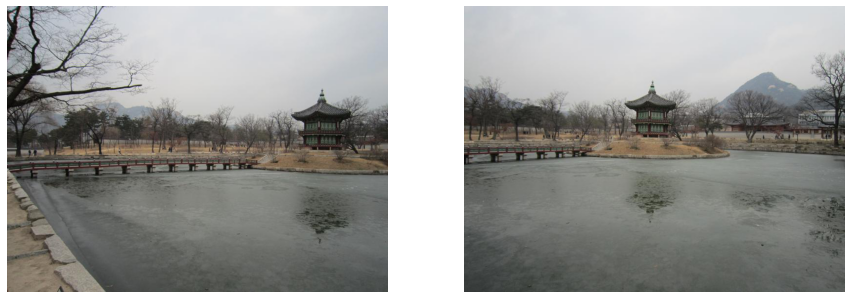

In [3]:
color_img1 = plt.imread('img1.jpg')
color_img2 = plt.imread('img2.jpg')

def plot_imgs(img1, img2):
  fig, ax = plt.subplots(1, 2, figsize=(15, 20))
  for a in ax:
    a.set_axis_off()
  ax[0].imshow(img1)
  ax[1].imshow(img2)

plot_imgs(color_img1, color_img2)

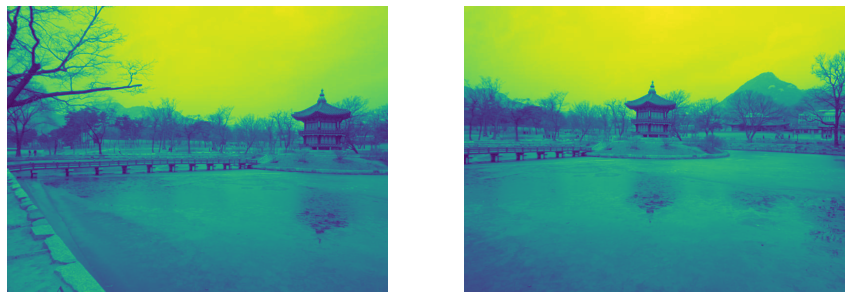

In [4]:
img1 = cv2.cvtColor(color_img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(color_img2, cv2.COLOR_BGR2GRAY)
plot_imgs(img1, img2)

In [5]:
MIN_MATCH_COUNT = 10

# Initiate SIFT detector
sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)

kp2, des2 = sift.detectAndCompute(img2,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

In [6]:
# kps = np.float32([kp1.pt for kp in kp1])
print(kp1)

(< cv2.KeyPoint 0x7f96e81ad060>, < cv2.KeyPoint 0x7f96d3d0e9c0>, < cv2.KeyPoint 0x7f96d3d0ec30>, < cv2.KeyPoint 0x7f96d3d0ec90>, < cv2.KeyPoint 0x7f96d3d0ec60>, < cv2.KeyPoint 0x7f96d3d0ecc0>, < cv2.KeyPoint 0x7f96d3d0ecf0>, < cv2.KeyPoint 0x7f96d3d0ed20>, < cv2.KeyPoint 0x7f96d3d0ed50>, < cv2.KeyPoint 0x7f96d3d0ed80>, < cv2.KeyPoint 0x7f96d3d0edb0>, < cv2.KeyPoint 0x7f96d3d0ede0>, < cv2.KeyPoint 0x7f96d3d0e840>, < cv2.KeyPoint 0x7f96d3d0ee10>, < cv2.KeyPoint 0x7f96d3d0e8d0>, < cv2.KeyPoint 0x7f96d3d0ee40>, < cv2.KeyPoint 0x7f96d3d0ee70>, < cv2.KeyPoint 0x7f96d3d0e990>, < cv2.KeyPoint 0x7f96d3d0eea0>, < cv2.KeyPoint 0x7f96d3d0ea20>, < cv2.KeyPoint 0x7f96d3d0eed0>, < cv2.KeyPoint 0x7f96d3d0ef00>, < cv2.KeyPoint 0x7f96d3d0ef30>, < cv2.KeyPoint 0x7f96d3d0ef60>, < cv2.KeyPoint 0x7f96d3d0ef90>, < cv2.KeyPoint 0x7f96d3d0efc0>, < cv2.KeyPoint 0x7f96d3d0e7b0>, < cv2.KeyPoint 0x7f96d3d0e7e0>, < cv2.KeyPoint 0x7f96d3d0e8a0>, < cv2.KeyPoint 0x7f96d3d0e930>, < cv2.KeyPoint 0x7f96d3ca3030>, < cv2.K

In [7]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

In [8]:
print(M,mask.shape)

[[ 1.82596188e+00 -7.09983435e-03 -5.25343776e+02]
 [ 2.76351186e-01  1.59050152e+00 -1.91740340e+02]
 [ 1.01925595e-03  1.15513541e-04  1.00000000e+00]] (377, 1)


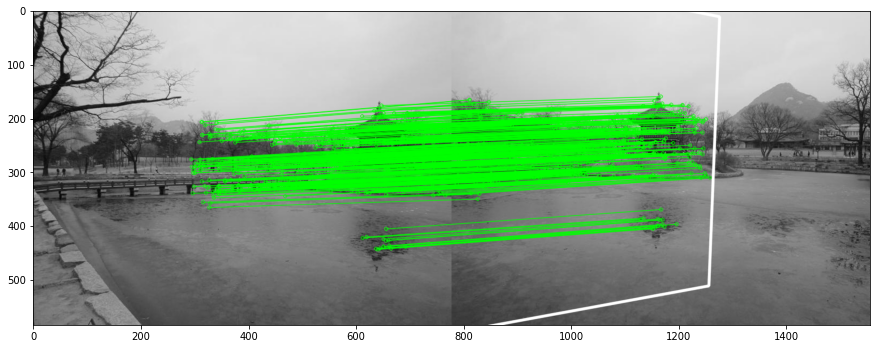

(<matplotlib.image.AxesImage at 0x7f96d59f9190>, None)

In [9]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.figure(figsize = (15,20))
plt.imshow(img3, 'gray'),plt.show()

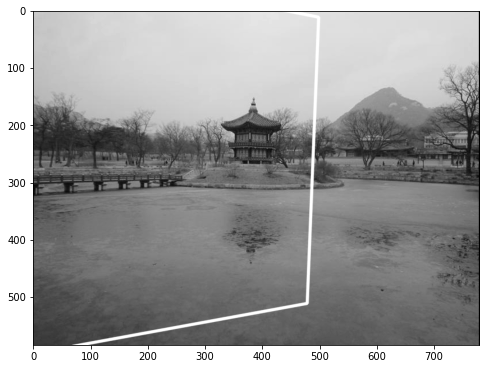

(<matplotlib.image.AxesImage at 0x7f96d1c425d0>, None)

In [12]:
result = cv2.warpPerspective(img1, M,(img1.shape[1] + img2.shape[1], img1.shape[0]))
result[0:img2.shape[0], 0:img2.shape[1]] = img2
plt.figure(figsize = (8,16))
plt.imshow(result[:,:780], 'gray'),plt.show()

[[ 1.82596188e+00 -7.09983435e-03 -5.25343776e+02]
 [ 2.76351186e-01  1.59050152e+00 -1.91740340e+02]
 [ 1.01925595e-03  1.15513541e-04  1.00000000e+00]] [[ 1  0 -5]
 [ 0  1 -5]
 [ 0  0  1]] [[ 1.82596188e+00 -0.00000000e+00  2.62671888e+03]
 [ 0.00000000e+00  1.59050152e+00  9.58701701e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


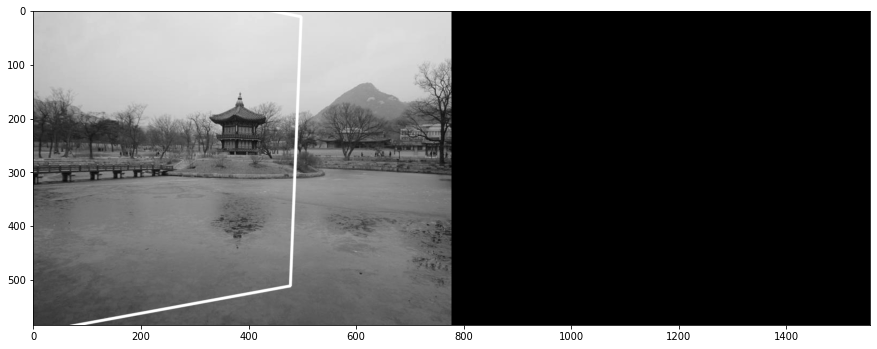

(<matplotlib.image.AxesImage at 0x7f96d1c4aed0>, None)

In [20]:
x_offset= -5
y_offset= -5
offset_matrix=np.matrix([[ 1 , 0 , x_offset],[ 0 , 1 , y_offset],[ 0 , 0 ,    1    ]])

Mfinal=np.multiply(M,offset_matrix)
print(M,offset_matrix,Mfinal)
result = cv2.warpPerspective(img1, Mfinal,(img1.shape[1] + img2.shape[1], img1.shape[0]))
# result = cv2.warpPerspective(img2, Mfinal,(img2.shape[1] + img1.shape[1], img2.shape[0]))

# result[0:img1.shape[0], 0:img1.shape[1]] = img1
result[0:img2.shape[0], 0:img2.shape[1]] = img2
plt.figure(figsize = (15,20))
plt.imshow(result, 'gray'),plt.show()